In [74]:
# scripts/03_train_neural_ode.jl

using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization,
      OptimizationOptimisers, Random, JLD2, Plots

In [75]:
sample = dataset[3]


(t = Float32[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], data = [0.2475898712873459 0.21801304817199707 … 2.5557069778442383 2.582380533218384; 1.4099113941192627 1.4002149105072021 … 2.8284144401550293 2.857808828353882; … ; 0.5212439894676208 0.5327474474906921 … 0.652839720249176 0.6492505669593811; 0.1418757140636444 0.14177671074867249 … 0.0370698906481266 0.04134576767683029], u0 = Float32[0.24758987, 1.4099114, -1.2959797, -1.0241026, -0.24932878, -0.21748976, 1.3986021, -2.5908859, -0.5422802, -0.29150307, -0.087712616, 0.48330042, 0.65955615, 1.0752139, 0.5433727, -0.13302399, 0.521244, 0.14187571])

Loading dataset...
Generating plot...
✅ Plot saved to: c:\Users\Welcome\SciML_NBody\main_scripts\..\plots\true_trajectory_plot_small.png


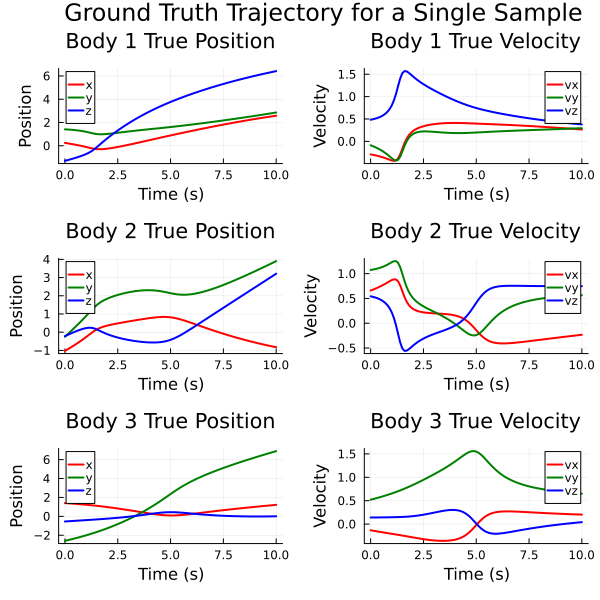

In [76]:
using JLD2
using Plots

println("Loading dataset...")
dataset = load(joinpath(@__DIR__, "..", "data", "nbody_dataset.jld2"), "dataset")

t_true = sample.t
data_true = sample.data
n_bodies = 3

println("Generating plot...")
plots_array = []
for body in 1:n_bodies
    p_pos = plot(title="Body $body True Position", xlabel="Time (s)", ylabel="Position")
    for (i, coord, color) in zip(1:3, ["x", "y", "z"], [:red, :green, :blue])
        idx = 3 * (body - 1) + i
        plot!(p_pos, t_true, data_true[idx, :], label=coord, lw=2, color=color)
    end
    push!(plots_array, p_pos)

    p_vel = plot(title="Body $body True Velocity", xlabel="Time (s)", ylabel="Velocity")
    for (i, coord, color) in zip(1:3, ["vx", "vy", "vz"], [:red, :green, :blue])
        idx = 9 + 3 * (body - 1) + i
        plot!(p_vel, t_true, data_true[idx, :], label=coord, lw=2, color=color)
    end
    push!(plots_array, p_vel)
end

final_plot = plot(plots_array...,
    layout=(n_bodies, 2),
    size=(600, 600), # Changed for a smaller plot
    plot_title="Ground Truth Trajectory for a Single Sample"
)

plots_dir = joinpath(@__DIR__, "..", "plots")
!isdir(plots_dir) && mkdir(plots_dir)
save_path = joinpath(plots_dir, "true_trajectory_plot_small.png")

savefig(final_plot, save_path)
println("✅ Plot saved to: $save_path")

display(final_plot)

In [77]:
# Dataset and stats
dataset = load(joinpath(@__DIR__, "..", "data", "nbody_dataset.jld2"), "dataset")

sample = dataset[3]
num_vars, num_timesteps = size(sample.data)

println("""
✅ N-Body Dataset Statistics:
---------------------------------
Total Trajectories:   $(length(dataset))
Time Span:            $(sample.t[1]) to $(round(sample.t[end], digits=1)) s
Timesteps / Variables:  $num_timesteps / $num_vars
Data Shape per Traj.: ($num_vars, $num_timesteps)
---------------------------------
""")

✅ N-Body Dataset Statistics:
---------------------------------
Total Trajectories:   100
Time Span:            0.0 to 10.0 s
Timesteps / Variables:  101 / 18
Data Shape per Traj.: (18, 101)
---------------------------------



In [78]:
# Set random seed for reproducibility
Random.seed!(1234)

# Hyperparameters
learning_rate = 0.01
max_iterations = 1000
hidden_layer_config = [64, 64]

# Initialization options:
# activation_function = tanh;       init_weight_func = Lux.glorot_uniform
# activation_function = sigmoid;    init_weight_func = Lux.glorot_uniform
# activation_function = relu;     init_weight_func = Lux.kaiming_uniform
activation_function = swish;    init_weight_func = Lux.glorot_uniform
init_bias_func = Lux.zeros32

t_ref = Float32.(dataset[67].t)
u0_ref = Float32.(dataset[67].u0)
data_ref = Float32.(dataset[67].data)

# Neural network architecture
rng = Random.default_rng()

TaskLocalRNG()

In [79]:
function create_lux_chain(input_dim, output_dim, hidden_layers, activation_fn;
                          init_weight, init_bias)
    layers = []
    current_dim = input_dim
    for hidden_dim in hidden_layers
        push!(layers, Lux.Dense(current_dim, hidden_dim, activation_fn;
                                init_weight=init_weight, init_bias=init_bias))
        current_dim = hidden_dim
    end
    push!(layers, Lux.Dense(current_dim, output_dim;
                            init_weight=init_weight, init_bias=init_bias))
    return Lux.Chain(layers...)
end

create_lux_chain (generic function with 1 method)

In [80]:
dudt_nn = create_lux_chain(length(u0_ref), length(u0_ref),
                           hidden_layer_config, activation_function;
                           init_weight=init_weight_func,
                           init_bias=init_bias_func)


Chain(
    layer_1 = Dense(18 => 64, swish),   # 1_216 parameters
    layer_2 = Dense(64 => 64, swish),   # 4_160 parameters
    layer_3 = Dense(64 => 18),          # 1_170 parameters
)         # Total: 6_546 parameters,
          #        plus 0 states.

In [81]:
p, st = Lux.setup(rng, dudt_nn)
ps = ComponentArray(p)

prob_neuralode = NeuralODE(dudt_nn, (t_ref[1], t_ref[end]), Tsit5();
                           saveat = t_ref)

NeuralODE(
    model = Chain(
        layer_1 = Dense(18 => 64, swish),  # 1_216 parameters
        layer_2 = Dense(64 => 64, swish),  # 4_160 parameters
        layer_3 = Dense(64 => 18),      # 1_170 parameters
    ),
)         # Total: 6_546 parameters,
          #        plus 0 states.

In [82]:
function loss_neuralode(p)
    pred = Array(prob_neuralode(u0_ref, p, st)[1])
    # println(size(pred))
    return sum(abs2, data_ref .- pred)
end

# To check the loss with current/initial parameters
loss_value = loss_neuralode(ps)
println("Current loss: $loss_value")

Current loss: 30849.14


In [83]:
function plot_predictions(p, iteration=nothing; save_path=nothing, display_plot=false)
    pred = Array(prob_neuralode(u0_ref, p, st)[1])
    
    plots_array = []
    for body in 1:3
        # Position Plot
        p_pos = plot(title="Body $body Positions", legend=false)
        for (i, coord, color) in zip(1:3, ["x", "y", "z"], [:red, :green, :blue])
            idx = 3*(body-1) + i
            plot!(p_pos, t_ref, data_ref[idx, :], lw=2, c=color)
            plot!(p_pos, t_ref, pred[idx, :], ls=:dash, lw=2, c=color)
        end
        push!(plots_array, p_pos)

        # Velocity Plot
        p_vel = plot(title="Body $body Velocities", legend=false)
        for (i, coord, color) in zip(1:3, ["vx", "vy", "vz"], [:red, :green, :blue])
            idx = 9 + 3*(body-1) + i
            plot!(p_vel, t_ref, data_ref[idx, :], lw=2, c=color)
            plot!(p_vel, t_ref, pred[idx, :], ls=:dash, lw=2, c=color)
        end
        push!(plots_array, p_vel)
    end

    title_str = isnothing(iteration) ? "Neural ODE Training Results" : "Neural ODE Predictions - Iteration $iteration"
    p_combined = plot(plots_array..., layout=(3,2), size=(600, 600),
                      plot_title=title_str)
    
    if !isnothing(save_path)
        savefig(p_combined, save_path)
    end
    
    if display_plot
        display(p_combined)
    end
    
    return p_combined
end

function plot_predictions1(p, iteration=nothing; save_path=nothing, display_plot=false)
    pred = Array(prob_neuralode(u0_ref, p, st)[1])
    
    plots_array = []
    
    # Body 1 x Position Plot
    p_pos = plot(title="Body 1 X Position", legend=false)
    idx = 1  # Body 1, x coordinate
    scatter!(p_pos, t_ref, data_ref[idx, :], c=:blue, marker=:circle, markersize=3)
    scatter!(p_pos, t_ref, pred[idx, :], c=:red, marker=:square, markersize=3)
    push!(plots_array, p_pos)

    # Body 1 x Velocity Plot
    p_vel = plot(title="Body 1 X Velocity", legend=false)
    idx = 10  # Body 1, vx coordinate (9 + 3*(1-1) + 1)
    scatter!(p_vel, t_ref, data_ref[idx, :], c=:blue, marker=:circle, markersize=3)
    scatter!(p_vel, t_ref, pred[idx, :], c=:red, marker=:square, markersize=3)
    push!(plots_array, p_vel)

    title_str = isnothing(iteration) ? "Neural ODE Training Results" : "Neural ODE Predictions - Iteration $iteration"
    p_combined = plot(plots_array..., layout=(1,2), size=(600, 300),
                      plot_title=title_str)
    
    if !isnothing(save_path)
        savefig(p_combined, save_path)
    end
    
    if display_plot
        display(p_combined)
    end
    
    return p_combined
end

plot_predictions1 (generic function with 2 methods)

In [84]:
# Training callback
iteration_counter = Ref(0)
callback = function (p, l)
    iteration_counter[] += 1
    if iteration_counter[] % 10 == 0
        println("Iteration $(iteration_counter[]): Loss = $l")
        # plot_predictions(p.u, iteration_counter[]; display_plot=true)
    end
    return false
end

#42 (generic function with 1 method)

In [85]:
# Optimization setup
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ps)

println("Starting training with $(max_iterations) iterations...")
training_time = @elapsed begin
    result_neuralode = Optimization.solve(optprob,
                                           OptimizationOptimisers.Adam(learning_rate);
                                           callback = callback,
                                           maxiters = max_iterations)
end
println("Training complete.")
println("Total training time: $(round(training_time, digits=2)) seconds for $(max_iterations) iterations")
println("Average time per iteration: $(round(training_time/max_iterations, digits=3)) seconds")

Starting training with 1000 iterations...
Iteration 10: Loss = 6562.161
Iteration 20: Loss = 1251.2527
Iteration 30: Loss = 682.61487
Iteration 40: Loss = 473.55
Iteration 50: Loss = 363.91644
Iteration 60: Loss = 293.64832
Iteration 70: Loss = 245.06863
Iteration 80: Loss = 203.17224
Iteration 90: Loss = 170.03174
Iteration 100: Loss = 142.88498
Iteration 110: Loss = 121.005005
Iteration 120: Loss = 103.08609
Iteration 130: Loss = 88.18663
Iteration 140: Loss = 75.807465
Iteration 150: Loss = 65.53319
Iteration 160: Loss = 56.9815
Iteration 170: Loss = 49.850185
Iteration 180: Loss = 119.81129
Iteration 190: Loss = 62.168095
Iteration 200: Loss = 46.725204
Iteration 210: Loss = 39.899704
Iteration 220: Loss = 34.75181
Iteration 230: Loss = 30.680016
Iteration 240: Loss = 27.34188
Iteration 250: Loss = 25.311962
Iteration 260: Loss = 23.692184
Iteration 270: Loss = 22.378914
Iteration 280: Loss = 21.298252
Iteration 290: Loss = 20.380789
Iteration 300: Loss = 19.580662
Iteration 310: L

In [93]:
# finetuning model 
using Optimization, OptimizationOptimJL
using Optim
optprob2 = remake(optprob; u0 = result_neuralode.u)
result_neuralode2 = Optimization.solve(optprob2, Optim.BFGS(; initial_stepnorm = 0.01);
    callback, allow_f_increases = false)

Iteration 1010: Loss = 7.5868754
Iteration 1020: Loss = 6.9385924
Iteration 1030: Loss = 6.2558246
Iteration 1040: Loss = 5.6309485
Iteration 1050: Loss = 5.136929
Iteration 1060: Loss = 4.3187084
Iteration 1070: Loss = 3.6737735
Iteration 1080: Loss = 3.261861
Iteration 1090: Loss = 2.9815078
Iteration 1100: Loss = 2.7570362
Iteration 1110: Loss = 2.5720806
Iteration 1120: Loss = 2.4128535
Iteration 1130: Loss = 2.2567961


retcode: Success
u: ComponentVector{Float32}(layer_1 = (weight = Float32[-0.08866895 0.19937393 … 0.27680066 -0.18402992; 0.090176776 -0.09657796 … -0.111377135 0.12938833; … ; -0.2076433 0.028985009 … -0.09008626 -0.1377353; 0.17000914 0.0574853 … -0.0908598 0.203958], bias = Float32[-0.07591741, -0.010254186, -0.0011105859, -0.022213342, -0.07110144, -0.050823644, -0.061907597, 0.07654458, -0.06577659, 0.0246347  …  0.022301495, -0.04696659, 0.033576556, -0.05247114, -0.067394376, 0.05151106, -0.07470148, -0.10073792, 0.08640946, -0.062626064]), layer_2 = (weight = Float32[0.13655953 0.07280467 … -0.13391183 -0.043332484; -0.046611067 0.0065469597 … 0.18697041 -0.19769515; … ; -0.08062378 -0.12092529 … 0.026799357 0.06658219; -0.2052741 -0.24834585 … -0.06707584 0.009596594], bias = Float32[0.053853728, -0.05097178, -0.057151828, -0.05452888, -0.10155759, -0.055689435, -0.027953874, -0.0410588, 0.068895034, -0.0016558233  …  -0.05587062, 0.013972352, -0.16162571, 0.021619864, -0.0315

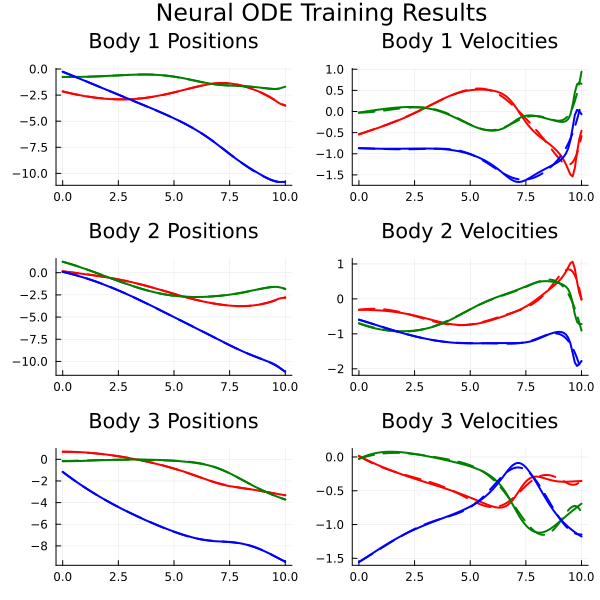

Saved trained model to data/trained_neural_ode.jld2


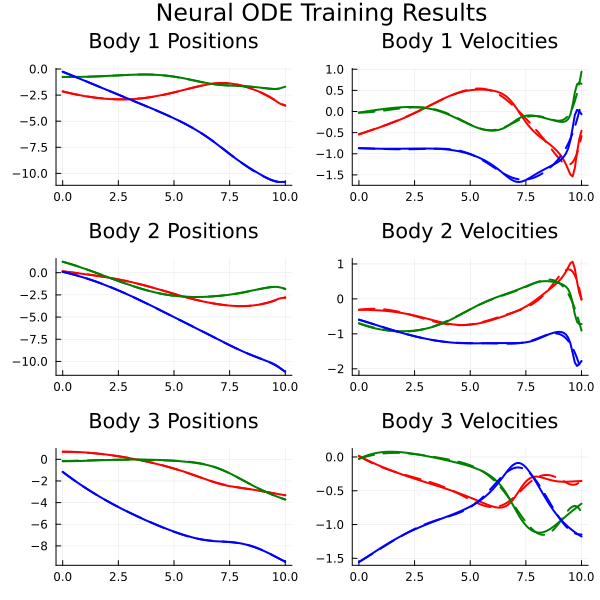

In [94]:
# Save trained model
ps_trained = result_neuralode2.u
jldsave(joinpath(@__DIR__, "..", "data", "trained_neural_ode.jld2");
        ps_trained, st, dudt_nn)
println("Saved trained model to data/trained_neural_ode.jld2")

# Final visualization
final_plot_path = joinpath(@__DIR__, "..", "plots", "neural_ode_training_results.png")
plot_predictions(ps_trained; save_path=final_plot_path, display_plot=true)